# 3.1 Implémentation d'un modèle de langue bi-gramme

**15 décembre 2025**

Adapté du tutoriel d'A. Karphathy "Makemore", première partie: <https://www.youtube.com/watch?v=PaCmpygFfXo>

Nous allons utiliser des données des codes issues de [Légifrance](https://www.legifrance.gouv.fr/liste/code?etatTexte=VIGUEUR&etatTexte=VIGUEUR_DIFF&page=1#code), et plus particulièrement dans ce chapitre les mots du [code civil](https://www.legifrance.gouv.fr/codes/texte_lc/LEGITEXT000006070721).


## Jeu de données: les mots du code civil

In [1]:
words = open('civil_mots.txt', 'r').read().splitlines()

In [2]:
len(words)
# Devrait afficher 7223

7223

In [3]:
words[40:50]

['acceptée',
 'acceptées',
 'accessible',
 'accession',
 'accessoire',
 'accessoirement',
 'accessoires',
 'accident',
 'accidents',
 'accoler']

## Calcul des bi-grammes pour les caractères de ces mots

In [4]:
# Caractère spécial indiquant le début ou la fin d'un mot
EOS='.'

In [5]:
# Exemple de calcul des bi-grammes d'un mot
b = {}  # Dictionnaire
for w in ['accessoire']:
    chs = [EOS] + list(w) + [EOS]
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        print(bigram)
        b[bigram] = b.get(bigram, 0) + 1

('.', 'a')
('a', 'c')
('c', 'c')
('c', 'e')
('e', 's')
('s', 's')
('s', 'o')
('o', 'i')
('i', 'r')
('r', 'e')
('e', '.')


In [6]:
# Calcul sur tous les mots
b = {}
for w in words:
    chs = [EOS] + list(w) + [EOS]
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [7]:
print("Nombre de bi-grammes:", len(b))
sorted(b.items(), key = lambda kv: -kv[1])[:20]

Nombre de bi-grammes: 554


[(('s', '.'), 1974),
 (('e', '.'), 1872),
 (('n', 't'), 1587),
 (('e', 'n'), 1427),
 (('o', 'n'), 1312),
 (('e', 's'), 1227),
 (('r', 'e'), 1200),
 (('t', '.'), 1187),
 (('t', 'i'), 1055),
 (('e', 'r'), 934),
 (('.', 'c'), 871),
 (('t', 'e'), 805),
 (('.', 'p'), 760),
 (('c', 'o'), 753),
 (('.', 'a'), 744),
 (('a', 'n'), 689),
 (('i', 't'), 669),
 (('i', 's'), 665),
 (('i', 'n'), 665),
 (('.', 'r'), 653)]

In [8]:
chars = sorted(list(set(''.join(words))))
print(chars)
nb_chars = len(chars) + 1  # On ajoute 1 pour EOS
print("Nombre de caractères distincts:", nb_chars)
# Détail amusant: il n'y a pas de 'k' dans le code civil

["'", '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ô', 'ù', 'û', 'œ']
Nombre de caractères distincts: 41


In [9]:
# "tokenisation"
# Dictionnaire permettant de passer d'un caractère à son identifiant entier
ctoi = {c:i+1 for i,c in enumerate(chars)}
ctoi['.'] = 0
print("CTOI =", ctoi)
# Dictionnaire permettant permettant de passer d'un entier à son caractère
itoc = {i:s for s,i in ctoi.items()}
print("ITOC =", itoc)

CTOI = {"'": 1, '-': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, 'à': 28, 'â': 29, 'ç': 30, 'è': 31, 'é': 32, 'ê': 33, 'ë': 34, 'î': 35, 'ï': 36, 'ô': 37, 'ù': 38, 'û': 39, 'œ': 40, '.': 0}
ITOC = {1: "'", 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 28: 'à', 29: 'â', 30: 'ç', 31: 'è', 32: 'é', 33: 'ê', 34: 'ë', 35: 'î', 36: 'ï', 37: 'ô', 38: 'ù', 39: 'û', 40: 'œ', 0: '.'}


## Utilisation d'une matrice (tenseur d'ordre 2) pour stocker les bi-grammes

In [10]:
import torch

# Construction d'une matrice 
N = torch.zeros((nb_chars, nb_chars), dtype=torch.int32)

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = ctoi[ch1]
        ix2 = ctoi[ch2]
        N[ix1, ix2] += 1
print(N.shape)
print(N)

torch.Size([41, 41])
tensor([[0, 0, 0,  ..., 0, 0, 2],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)


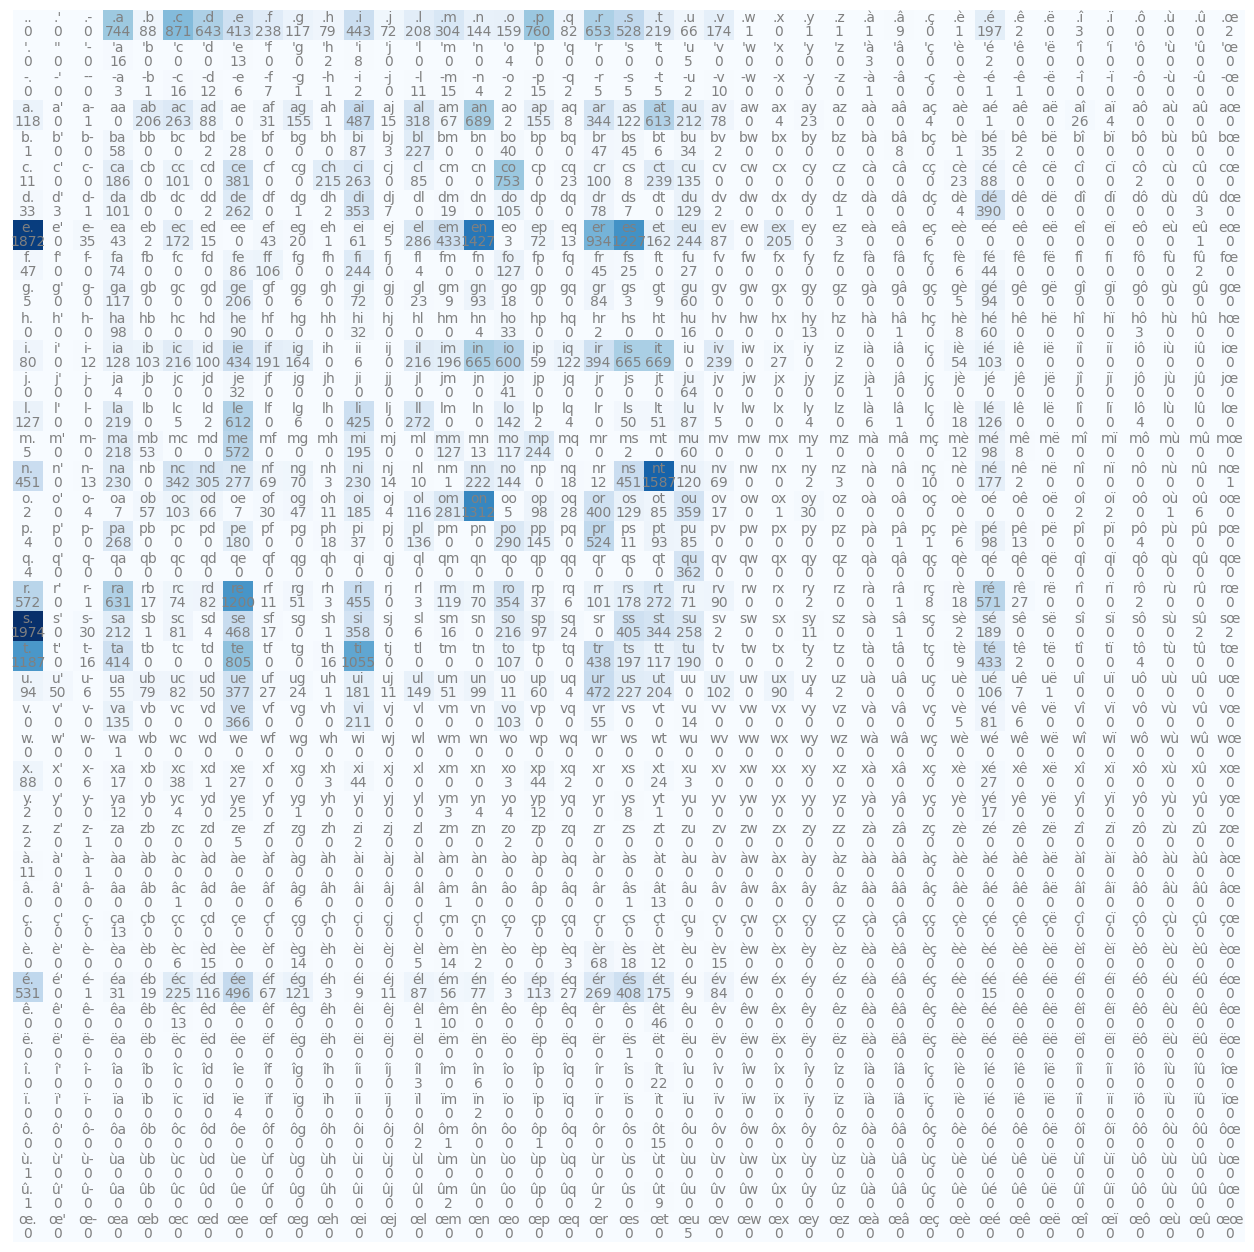

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(nb_chars):
    for j in range(nb_chars):
        chstr = itoc[i] + itoc[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

## Passage d'un comptage au maximum de vraissemblance

In [13]:
# Première ligne, comptages pour les premières lettres des mots
N[0]
# La lettre 'c' est la plus courante en début de mot

tensor([  0,   0,   0, 744,  88, 871, 643, 413, 238, 117,  79, 443,  72, 208,
        304, 144, 159, 760,  82, 653, 528, 219,  66, 174,   1,   0,   1,   1,
          1,   9,   0,   1, 197,   2,   0,   3,   0,   0,   0,   0,   2],
       dtype=torch.int32)

On va transformer ces comptages en distribution de probabilité `p` pour la première ligne `N[0]`, en transformant d'abord chaque élément en `float` puis en normalisant par la somme des éléments.

In [16]:
# On va transformer ces comptages en distribution de probabilité, en transformant en float
# chaque élément
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.0000, 0.0000, 0.1030, 0.0122, 0.1206, 0.0890, 0.0572, 0.0330,
        0.0162, 0.0109, 0.0613, 0.0100, 0.0288, 0.0421, 0.0199, 0.0220, 0.1052,
        0.0114, 0.0904, 0.0731, 0.0303, 0.0091, 0.0241, 0.0001, 0.0000, 0.0001,
        0.0001, 0.0001, 0.0012, 0.0000, 0.0001, 0.0273, 0.0003, 0.0000, 0.0004,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0003])

In [17]:
# On peut le faire sur toute la matrice, ligne par ligne, pour obtenir
# une matrice de probabilités
P = N.float()
P /= P.sum(1, keepdims=True)
P

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.7689e-04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [7.1429e-02, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [18]:
P.shape

torch.Size([41, 41])

## Échantillonage

In [19]:
# On va échantilloner pour obtenir un 
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
print(ix, '->', itoc[ix])
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
print(ix, '->', itoc[ix])

32 -> é
3 -> a


In [20]:
# 15 tirages aléatoires
torch.multinomial(p, num_samples=15, replacement=True, generator=g)

tensor([21,  3,  4,  5,  9, 11, 29, 19,  5,  8, 13,  7, 14,  5, 15])

## Synthèse: code complet de création du modèle et de son échantillonage

In [21]:
#
# Générateur des mots selon notre modèle de langue génératif bigrams par comptage
#
import torch

# Lecture des données
EOS='.'
words = open('civil_mots.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
nb_chars = len(chars) + 1  # On ajoute 1 pour EOS

# Dictionnaires caractère <-> entier
ctoi = {s:i+1 for i,s in enumerate(chars)}
ctoi['.'] = 0
itoc = {i:s for s,i in ctoi.items()}

# Construction d'une matrice contenant le comptage des bigrams
N = torch.zeros((nb_chars, nb_chars), dtype=torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = ctoi[ch1]
        ix2 = ctoi[ch2]
        N[ix1, ix2] += 1

# Matrice de probabilité
P = N.float()
P /= P.sum(1, keepdims=True)

# Générateur aléatoire
g = torch.Generator().manual_seed(2147483647)

def generate_words(num, P, g):
    # Génération de 5 mots
    for i in range(num):
        out = []
        ix = 0
        while True:
            p = P[ix]
            ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            out.append(itoc[ix])
            if ix == 0:
                  break
        print(''.join(out))

generate_words(5, P, g)

éssanée.
mexcororér.
monts.
ex.
moût.


## Fonction de perte: log-vraissemblance


Lorsque l'on créé un modèle de langue, nous allons chercher à mesurer sa qualité.
On cherche à maximiser la vraissemblance (_likelihood_) des données, considérant les paramètres du modèle.

Il est équivalent et plus commode de maximiser le logarithme naturel de cette vraisemblance (log est strictement croissant), ce qui revient à minimiser l'opposée de cette log-vraissemblance.

En pratique, on va cherche à minimiser la moyenne de l'opposée de la log-vraissemblance.

In [22]:
log_likelihood = 0.0
n = 0

for w in words:
#for w in ["espérance"]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = ctoi[ch1]
        ix2 = ctoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-158565.9375)
nll=tensor(158565.9375)
2.3438470363616943


Ce "loss" à 2.34 est donc la mesure de qualité de notre modèle bigram par comptage.

## Lissage

Notre modèle se comporte de manière stricte lorsqu'il rencontre une combinaison de caractères qu'il ne connaît pas. Par exemple, si on cherche le score d'un mot comme "espérancejq", où la combinaison "jq" a une probabilité 0:

In [24]:
log_likelihood = 0.0
n = 0

for w in ["espérancejq"]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = ctoi[ch1]
        ix2 = ctoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

.e: 0.0572 -2.8616
es: 0.1664 -1.7931
sp: 0.0205 -3.8851
pé: 0.0512 -2.9720
ér: 0.0911 -2.3959
ra: 0.1255 -2.0753
an: 0.1708 -1.7675
nc: 0.0708 -2.6484
ce: 0.1458 -1.9255
ej: 0.0007 -7.2960
jq: 0.0000 -inf
q.: 0.0109 -4.5163
log_likelihood=tensor(-inf)
nll=tensor(inf)
inf


On a un loss qui est à l'infini car l'une de probabilité transformée en log passe à l'infini. Habituellement, on fait donc du "lissage" de modèles (smoothing), en ajoutant par exemple 1 à tous les comptage avant de calculer les probabilités (noter le `N+1` ci-dessous):

In [25]:
P = (N+1).float()
P /= P.sum(1, keepdims=True)

In [26]:
log_likelihood = 0.0
n = 0

for w in ["espérancejq"]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = ctoi[ch1]
        ix2 = ctoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

.e: 0.0570 -2.8648
es: 0.1657 -1.7978
sp: 0.0206 -3.8835
pé: 0.0506 -2.9830
ér: 0.0902 -2.4059
ra: 0.1247 -2.0818
an: 0.1693 -1.7762
nc: 0.0704 -2.6539
ce: 0.1439 -1.9384
ej: 0.0008 -7.1192
jq: 0.0055 -5.2095
q.: 0.0123 -4.3994
log_likelihood=tensor(-39.1135)
nll=tensor(39.1135)
3.2594597339630127
